# CV fastai model

In [21]:
#!pip install neptune-client

In [1]:
import pickle

import numpy as np
import neptune
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.text import *
from sklearn import metrics


from torch.nn import _reduction as _Reduction

import torch

### TODO
- figure out how the metric used for evaluation exactly works. 
If all its classes are balanced to have the same impact(= occurrences * class weight) then create loss function that weight each class during a training set accordingly
- add custom toxic metric to fastai callbacks
- force model to have prediction in range 0 to 1

In [2]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:,1:2])(data[:,:1],targets[:,:1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:,1:],targets[:,2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2


In [3]:
# now its wrong (pred-target*weight)**2
# should be weight*(pred-target)**2 


class L1LossFlat(nn.L1Loss):
    "Mean Absolute Error Loss"
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        weighted_targets = []
        weighted_inputs = []
        
        for single_target, single_input in target, input:
            if single_target - 26 < 0:
                weighted_targets.append((single_target - 25) * 0.25)
                weighted_inputs.append(single_input * 0.25)
            elif single_target - 51 < 0:
                weighted_targets.append((single_target - 50) * 0.50)
                weighted_inputs.append(single_input * 0.50)
            else:# single_target - 75 < 0:
                weighted_targets.append((single_target - 75) * 0.75)
                weighted_inputs.append(single_input * 0.75)
        
        final_target = torch.FloatTensor(weighted_targets)
        final_target = torch.FloatTensor(weighted_inputs)
    
        return super().forward(weighted_inputs.view(-1), final_target.view(-1))

In [4]:
def cal_loss(t, y, weight, val):
    return weight * (((t-val)-sigmoid(y))**2)

def calcuale_single_sample_weighted_loss(single_target, single_input):
    if single_target <= 26:
        loss = cal_loss(single_target, single_input, 0.25, 25)
    elif single_target <= 51:
        loss = cal_loss(single_target, single_input, 0.50, 50)
    else:# single_target - 75 < 0:
        loss = cal_loss(single_target, single_input, 0.75, 75)
    return loss
    
def calcuale_single_batch_weighted_loss(batch_targets, batch_inputs):
    return [calcuale_single_sample_weighted_loss(single_target, single_input) for single_target, single_input 
     in zip(batch_targets, batch_inputs)]

def calculate_batch_list_weighted_loss(batch_targets_list, batch_inputs_list):
    return [calcuale_single_batch_weighted_loss(batch_targets, batch_inputs) for batch_targets, batch_inputs
            in zip(batch_targets_list, batch_inputs_list)]

def cust_mse_loss(input, target, aux_func, size_average=None, reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[bool], Optional[bool], str) -> Tensor

    if not (target.size() == input.size()):
        warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                      "This will likely lead to incorrect results due to broadcasting. "
                      "Please ensure they have the same size.".format(target.size(), input.size()),
                      stacklevel=2)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
    if target.requires_grad:# dont want grad in target
        raise ValueError('O a jednak to wchodzi czasem')
    else:
        
        expanded_input, expanded_target = torch.broadcast_tensors(input, target)
        #expanded_input = aux_func(expanded_input) # norm nn output into 0 1 range
        
        #return torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
        # 1. rozbic na 3 tensory 
        
        mask_25 = np.where(expanded_target <= 201)
        mask_50 = np.where((expanded_target <= 10000) & (expanded_target > 201))
#         mask_75 = np.where(expanded_target >= 75)
    
        expanded_input_25 = expanded_input[mask_25].view(len(mask_25[0]) , 1)
        expanded_input_50 = expanded_input[mask_50].view(len(mask_50[0]) , 1)
#         expanded_input_75 = expanded_input[mask_75].view(expanded_input.shape[0] , 1)
        
        expanded_target_25 = expanded_target[mask_25].view(len(mask_25[0]) , 1) - 200
        expanded_target_50 = expanded_target[mask_50].view(len(mask_50[0]) , 1) - 500
#         expanded_target_75 = expanded_target[mask_75] - 75
        
        
        #return torch._C._nn.mse_loss(expanded_input_25, expanded_target_25, _Reduction.get_enum(reduction)) #* 0.25
        # 2. _C.mse_loss
        ret_25 = torch._C._nn.mse_loss(expanded_input_25, expanded_target_25, _Reduction.get_enum(reduction)) * 0.25
        ret_50 = torch._C._nn.mse_loss(expanded_input_50, expanded_target_50, _Reduction.get_enum(reduction)) * 0.50
        # import pdb;pdb.set_trace()
#         ret_75 = torch._C._nn.mse_loss(expanded_input_75, expanded_target_75, _Reduction.get_enum(reduction)) * 0.75
        
        ret_25 = ret_25 if not torch.isnan(ret_25) else 0
        ret_50 = ret_50 if not torch.isnan(ret_50) else 0
#         ret_75 = ret_75 if not torch.isnan(ret_75) else 0
        
        # 3. przemnozyc przez wage i sum
        final_loss = ret_25 + ret_50 #+ ret_75
        
        try:
            final_loss.grad_fn
        except:
            import pdb;pdb.set_trace()
        
        #ret = torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
    
    return final_loss

class customMSELoss(torch.nn.MSELoss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(torch.nn.MSELoss, self).__init__(size_average, reduce, reduction)
        self.sig = nn.Sigmoid()
        
    def forward(self, input, target):
        return cust_mse_loss(input, target, reduction=self.reduction, aux_func=self.sig)

In [6]:
# loss = customMSELoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5) + 50
# output = loss(input, target)
# output.backward()
# # weighted_losses
# # ret_75 if ret_75 != np.nan else 0

# # v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
# # y.backward(v)

# # print(x.grad)


epoch 0, loss 19.32220458984375
target + 10 tensor([[200.7500],
        [200.7000],
        [200.5500],
        [200.6000],
        [500.5500],
        [500.5000],
        [500.4500]])
results tensor([[-0.7757],
        [-1.2747],
        [-1.7737],
        [-2.2727],
        [-2.7717],
        [-3.2707],
        [-3.7697]], grad_fn=<AddmmBackward>)
epoch 500, loss 0.0020661072339862585
target + 10 tensor([[200.7500],
        [200.7000],
        [200.5500],
        [200.6000],
        [500.5500],
        [500.5000],
        [500.4500]])
results tensor([[0.7242],
        [0.6783],
        [0.6323],
        [0.5864],
        [0.5404],
        [0.4944],
        [0.4485]], grad_fn=<AddmmBackward>)
epoch 1000, loss 0.002065882785245776
target + 10 tensor([[200.7500],
        [200.7000],
        [200.5500],
        [200.6000],
        [500.5500],
        [500.5000],
        [500.4500]])
results tensor([[0.7249],
        [0.6788],
        [0.6326],
        [0.5865],
        [0.5404],
        

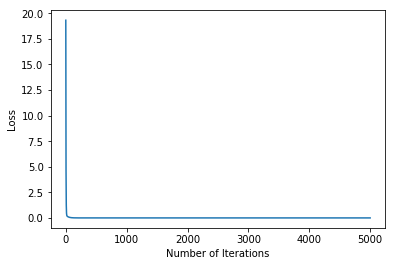

tensor([[0.6737],
        [0.6635],
        [0.6531],
        [0.6426],
        [0.6319],
        [0.6211],
        [0.6102]], grad_fn=<SigmoidBackward>)

In [5]:
# libraries
import torch      
from torch.autograd import Variable     
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")

car_prices_array = [1,2,3,4,5,6,7]
car_price_np = np.array(car_prices_array,dtype=np.float32)
car_price_np = car_price_np.reshape(-1,1)
car_price_tensor = Variable(torch.from_numpy(car_price_np))

# lets define number of car sell
number_of_car_sell_array = [ 200.75, 200.7, 200.55, 200.60, 500.55, 500.50, 500.45]
number_of_car_sell_np = np.array(number_of_car_sell_array,dtype=np.float32)
number_of_car_sell_np = number_of_car_sell_np.reshape(-1,1)
org_price = Variable(torch.from_numpy(number_of_car_sell_np))
number_of_car_sell_tensor = org_price #+ 10 # target

# Linear Regression with Pytorch



# create class
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        # super function. It inherits from nn.Module and we can access everythink in nn.Module
        super(LinearRegression,self).__init__()
        # Linear function.
        self.linear = nn.Linear(input_dim,output_dim)

    def forward(self,x):
        return self.linear(x)
    
# define model
input_dim = 1
output_dim = 1
model = LinearRegression(input_dim,output_dim) # input and output size are 1

# MSE
#mse =  nn.MSELoss()
mse =  customMSELoss()

# Optimization (find parameters that minimize error)
learning_rate = 0.02   # how fast we reach best parameters
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

# train model
loss_list = []
iteration_number = 5001
for iteration in range(iteration_number):
        
    # optimization
    optimizer.zero_grad() 
    
    # Forward to get output
    results = model(car_price_tensor)
    
    # Calculate Loss
    loss = mse(results, number_of_car_sell_tensor)
    
    # backward propagation
    loss.backward()
    
    # Updating parameters
    optimizer.step()
    
    # store loss
    loss_list.append(loss.data)
    
    
    # print loss
    if(iteration % 500 == 0):
        print('epoch {}, loss {}'.format(iteration, loss.data))
        print('target + 10',number_of_car_sell_tensor)
        print('results',results)
        #print('org_price',org_price)
        
plt.plot(range(iteration_number), loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

s = nn.Sigmoid()
s(results)

In [ ]:
expanded_input_25

tensor([[0.6974],
        [0.6612],
        [0.6229],
        [0.5831],
        [0.5422],
        [0.5006],
        [0.4591]], grad_fn=<SigmoidBackward>)

In [41]:
def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Parameters

In [42]:
k_folds = 8
target_col_name = 'target'
target_class_col_name = 'class_target'
x_col_name = 'comment_text'

epochs = 1
layer1_lr = 2e-2
layer2_lr = slice(1e-2/(2.6**4),1e-2)
momentum = (0.8,0.7)
loss_function = customMSELoss
DROP_MULT = 0.5
freeze_layer_idx = -2
architecture = AWD_LSTM

bs = 40
SEED = 777
seed_everything(SEED)

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

### Paths

In [43]:
# data
path = Path('/home/jupyter/toxic')
clas_csv_file = 'toxic_train.csv'
test_csv_file = 'toxic_test.csv'

# pretrained
encoder_file = 'fine_tuned_encoder_basic_toxic_lm15ep_extended'
data_lm_file = 'data_lm_basic_toxic_extended.pkl'

# results
exp_nb = 2
model_cv_result_file = 'toxic_test_cv_{}'
model_prod_cv_result_file = 'toxic_production_cv_{}'
k_folds_file = 'holdout_and_k_folds_idxs_exp_nb_{}.pkl'.format(exp_nb)
models_performance_file = 'toxic_CV_models_performance_exp_nb_{}.pkl'.format(exp_nb)
submission_predictions = 'toxic_CV_submission_exp_nb_{}.csv'.format(exp_nb)

final_model_result_file = 'toxic_final_model_{}'.format(exp_nb)
final_model_prod_result_file = 'toxic_production_final_{}'.format(exp_nb)
final_submission_predictions = 'toxic_final_submission_exp_nb_{}.csv'.format(exp_nb)

### Start Neptune experiment logging

In [44]:
# neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiJlNjA0OGZlMC0yODI5LTQ4ZDgtYjYyNi02NmUzZmI0MDNjNzYifQ==',
#              project_qualified_name='lachonman/toxic-bias')

# nep_exp = neptune.create_experiment(name='FastAI_regression_exp_nb_{}'.format(exp_nb),
#                           description=' Regression model implemented in FastAI that predicts'
#                           'probablity that given text belongs to toxic category. It uses pretrained'
#                           'Language Model that was trained on train+test and old toxic text corpora.'
#                           'Official metric used to evaluate model performance is "toxic_metric".'
#                           'Sorted stratificated k fold cross validation with 1'
#                           'holdout is used to tune paramters and measure metrics.',
#                           params={'loss_func': str(loss_function.__name__),
#                                   'lr_layer1': layer1_lr,
#                                   'lr_layer2': layer2_lr,
#                                   'momentum': momentum,
#                                   'epochs_count': epochs,
#                                   'dropout': DROP_MULT,
#                                   'freeze_layer_idx': freeze_layer_idx,
#                                   'architecture': architecture,
#                                   'k_folds': k_folds})

# nep_exp.append_tag('regression')
# nep_exp.append_tag('k folds CV')
# nep_exp.append_tag('pretrained extended LangModel')

In [45]:
def get_k_stratified_folds_indexes_given_continues_variable(df, k_folds, continuous_target_col_name):
    nb_samples = df.shape[0]
    split_remainder = nb_samples%k_folds
    groups_count = nb_samples//k_folds
    
    idxs_train_remainder = df[:split_remainder].index.values
    idxs_train_trimmed = df[split_remainder:]

    idxs_train_sorted = idxs_train_trimmed.sort_values(by=continuous_target_col_name).index.values

    k_groups = np.split(idxs_train_sorted, groups_count)
    list(map(np.random.shuffle, k_groups))
    folds_idxs = [np.array(x) for x in zip(*k_groups)]
    folds_idxs[0] = np.concatenate([folds_idxs[0], idxs_train_remainder])
    
    return np.array(folds_idxs)

def get_train_and_valid_idxs_split_given_fold_nb(folds_idxs, k):
    mask = np.ones(len(folds_idxs), dtype=bool)
    mask[k] = 0
    folds_idxs[mask]
    train_idxs = np.concatenate(folds_idxs[mask])
    
    test_idxs = folds_idxs[1]
    return train_idxs, test_idxs

# Convert taget and identity columns to booleans
def get_col_converted_to_bool(df, col_name):
    return np.where(df[col_name] >= 0.5, True, False)
    
def get_df_with_converted_categorical_cols_to_bool(df, categorical_cols):
    for col in categorical_cols:
        df[col] = get_col_converted_to_bool(df, col)
    return df

def get_df_with_class_target_col(df, target_col_name, target_class_col_name):
    df[target_class_col_name] = get_col_converted_to_bool(df, target_col_name)
    return df

In [46]:
# Convert taget and identity columns to booleans
def get_col_converted_to_bool(df, col_name):
    return np.where(df[col_name] >= 0.5, True, False)
    
def get_df_with_converted_categorical_cols_to_bool(df, categorical_cols):
    for col in categorical_cols:
        df[col] = get_col_converted_to_bool(df, col)
    return df

def get_df_with_class_target_col(df, target_col_name, target_class_col_name):
    df[target_class_col_name] = get_col_converted_to_bool(df, target_col_name)
    return df

In [47]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [48]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [49]:
class ToxicMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func):
        # If it's a partial, use func.func
        name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0)
        val = self.func(last_output, *last_target)
        self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)

### Load data and split into folds using sorted stratification

In [50]:
df_train_initial = pd.read_csv(path/clas_csv_file)[:1000]

In [51]:
test_df = pd.read_csv(path/test_csv_file)[:1000]

In [52]:
df_train_initial = get_df_with_converted_categorical_cols_to_bool(
    df=df_train_initial,
    categorical_cols=identity_columns)
df_train_initial = get_df_with_class_target_col(
    df=df_train_initial,
    target_col_name=target_col_name,
    target_class_col_name=target_class_col_name)

In [53]:
df_train_initial = df_train_initial.sample(frac=1 ,random_state=SEED)

holdout_and_k_folds_idxs = get_k_stratified_folds_indexes_given_continues_variable(df_train_initial, k_folds, target_col_name)

### Weighting samples so it better suit toxic metric

### Save folds splits

In [ ]:
# with open(k_folds_file, 'wb') as f:
#     pickle.dump(holdout_and_k_folds_idxs, f)

### Load folds splits

In [ ]:
# with open(k_folds_file, 'rb') as f:
#     holdout_and_k_folds_idxs = pickle.load(f)

In [55]:
holdout_idx = holdout_and_k_folds_idxs[0]
folds_idxs = holdout_and_k_folds_idxs[1:]

### Load language model data

In [56]:
data_lm = load_data(path, data_lm_file, bs=bs)

### Train regression models and perform cross validation

- add indexes when saving predictions
- create cv version that splits only into train 0.8 / valid 0.1 / holdout 0.1
- create grid seach over 
  - problem aproach
    - regression + languge model
    - classification (probs as result) + languge model
  - model types
    - AWD
    - Transformer
    - BERT
    - ELMo?
    - random forest
    - xgboost
  - loss functions 
    - MSE for reg
    - MSE_L1 for reg
    - sth for class (look for it in kernels)
  - parameters 
    - lr per layer
    - moms
    - epoch
    - unfreezes

- add scoring of test predictions
- add combining folds e.g 10 folds -> 1 holdout, 3x3 train_set
- add informative printing cuz i have no idea whats the progress

In [57]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
#         preds = last_output.argmax(1)
#         self.correct += ((preds==0) * (last_target==0)).float().sum()
#         self.total += (preds==0).float().sum()
        weighted_targets = []

        for single_target in target:
            if single_target <= 26:
                weighted_targets.append((single_target - 25))
            elif single_target <= 51:
                weighted_targets.append((single_target - 50))
            else:# single_target - 75 < 0:
                weighted_targets.append((single_target - 75))

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.correct/self.total)

In [58]:
x_train = df_train_initial['comment_text']
#y_aux_train = df_train_initial[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = test_df['comment_text']

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Overall
weights = np.ones((len(x_train),)) / 4
# Subgroup
weights += (df_train_initial[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (df_train_initial['target'].values>=0.5).astype(bool).astype(np.int) +
   (df_train_initial[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (df_train_initial['target'].values<0.5).astype(bool).astype(np.int) +
   (df_train_initial[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
#loss_weight = 1.0 / weights.mean()
#y_train = np.vstack([(df_train_initial['target'].values>=0.5).astype(np.int),weights]).T

In [59]:
set(weights)

{0.25, 0.5, 0.75}

In [60]:
#df_train_initial[['male', 'female']] = df_train_initial[['male', 'female']].fillna(0)

In [61]:
df_train_initial['weight_target'] = df_train_initial[target_col_name] + weights * 100

In [62]:
df_train_initial['weight_target'][500:505]

66     25.0
445    25.2
364    25.0
493    25.0
971    25.0
Name: weight_target, dtype: float64

In [63]:
# models_performance = {}
# # if holdout then k-1 cuz one fold went on holdout
# for k in range(k_folds-1):

train_idxs, valid_idxs = get_train_and_valid_idxs_split_given_fold_nb(folds_idxs, 0)

data_clas = (TextList.from_df(df_train_initial, path=path, cols=[x_col_name], vocab=data_lm.vocab)
         .split_by_idxs(train_idx=train_idxs, valid_idx=valid_idxs)
         .label_from_df(cols='weight_target', label_cls=FloatList)            
         .databunch(bs=bs))

learn = text_classifier_learner(data_clas, architecture, drop_mult=DROP_MULT)
learn.load_encoder(encoder_file)

In [64]:
# last_output, last_target
learn.loss = customMSELoss
learn.fit_one_cycle(10, layer1_lr, moms=momentum)

In [65]:
learn.data.add_test(df_train_initial[x_col_name][holdout_idx])
prob_preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
batch_preds = [pred[0] for pred in prob_preds[0].numpy()]

In [66]:
batch_preds

[53.224167,
 25.955189,
 21.693462,
 25.908705,
 25.11745,
 23.378658,
 28.083395,
 23.929243,
 22.451435,
 26.849058,
 23.779373,
 28.854162,
 23.712963,
 24.309643,
 29.049374,
 22.424473,
 25.899391,
 25.49664,
 28.233181,
 27.272953,
 24.244862,
 19.474722,
 25.313824,
 36.309692,
 34.14599,
 25.395668,
 21.27108,
 27.427982,
 40.219986,
 24.518917,
 43.775364,
 21.797321,
 21.078962,
 28.066322,
 25.311613,
 29.203167,
 31.090553,
 23.50661,
 26.769037,
 16.82581,
 27.543715,
 32.05392,
 24.569706,
 23.50784,
 29.664946,
 29.756279,
 26.806696,
 19.667274,
 32.63333,
 21.896456,
 27.528214,
 26.94942,
 13.182105,
 25.931555,
 25.11837,
 24.238663,
 27.44644,
 30.142298,
 31.07964,
 31.021734,
 27.559414,
 17.76423,
 25.026543,
 26.442833,
 21.9014,
 24.262718,
 29.935669,
 25.001299,
 42.248592,
 33.98621,
 25.65431,
 28.947943,
 21.00468,
 28.445036,
 20.03914,
 21.003757,
 26.110317,
 23.767643,
 27.849623,
 24.379221,
 27.373848,
 24.67942,
 23.784895,
 25.278465,
 28.292519,
 

In [19]:
# ### Save models performance
# with open(models_performance_file, 'wb') as f:
#     pickle.dump(models_performance, f)

In [20]:
# ### Check if models performance saved correctly
# with open(models_performance_file, 'rb') as f:
#     models_performance = pickle.load(f)

In [68]:
??Learner

Init signature:
Learner(
    ['data: fastai.basic_data.DataBunch', 'model: torch.nn.modules.module.Module', "opt_func: Callable = functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))", 'loss_func: Callable = None', 'metrics: Collection[Callable] = None', 'true_wd: bool = True', 'bn_wd: bool = True', 'wd: Union[float, Collection[float]] = 0.01', 'train_bn: bool = True', 'path: str = None', "model_dir: Union[pathlib.Path, str] = 'models'", 'callback_fns: Collection[Callable] = None', 'callbacks: Collection[fastai.callback.Callback] = <factory>', 'layer_groups: Collection[torch.nn.modules.module.Module] = None', 'add_time: bool = True'],
) -> None
Source:        
class Learner():
    "Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`."
    data:DataBunch
    model:nn.Module
    opt_func:Callable=AdamW
    loss_func:Callable=None
    metrics:Collection[Callable]=None
    true_wd:bool=True
    bn_wd:bool=True
    wd:Floats=defaults.wd
    tr

### Load models and do predictions on testset
Do that to check if cross validation produces good aproximation of how well the model generalizes. 
For real prediction train best model on all the data
- check if after load_lerner input is tokenized

In [21]:
# test_df = pd.read_csv(path/test_csv_file)

In [22]:
# group_preds = []
# for k in range(k_folds-1):
#     learn = load_learner(path, model_prod_cv_result_file.format(k))
    
#     learn.data.add_test(test_df[x_col_name])
#     prob_preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
#     batch_preds = [pred[0] for pred in prob_preds[0].numpy()]
#     group_preds.append(batch_preds)
    
# avg_preds = np.mean(group_preds, axis=0)
# test_df['prediction'] = avg_preds
# test_df[['id','prediction']].to_csv(path/submission_predictions, index=False)

## Metrics
- Should the models be evaluated on holdout if the metric that is used to pick best models into the ensamble is holdout accuracy? And then ensambles themselfs are picked based on thier accuracy on holdout.
- Use that i have k folds to aproximate how sure in its predictions final model will be(calcualte vairance using predictions from each fold)

### Train loss

In [23]:
train_folds_losses = []
for model_nb in models_performance:
    train_loss = models_performance[model_nb]['train_loss']
    train_score = [float(step.numpy()) for step in train_loss]
    train_folds_losses.append(train_score)

folds_train_losses = [x[-1] for x in train_folds_losses]
print('folds train losses', folds_train_losses)
avg_train_losses = np.mean(train_folds_losses, axis=0)
avg_train_loss = avg_train_losses[-1]
print('avg train loss', avg_train_loss)

folds train losses [0.018044915050268173, 0.019446002319455147, 0.018564680591225624, 0.017788488417863846, 0.018882934004068375, 0.01710507646203041, 0.017085056751966476]
avg train loss 0.01813102194241115


### Valid loss

In [24]:
valid_folds_losses = [models_performance[x]['valid_loss'][-1] for x in models_performance]
print('folds valid losses', valid_folds_losses)
avg_valid_loss = np.mean(valid_folds_losses, axis=0)
print('avg valid loss', avg_valid_loss)

folds valid losses [0.5292527, 54.811653, 0.017135596, 0.29703587, 0.026240299, 26.354286, 0.049951334]
avg valid loss 11.726507


### Houldout loss and acc

- check if order of samples df is the same as in prediction (predictions have the same indexes as saved in holdout_idxs)

In [26]:
holdout_group_preds = [models_performance[x]['holdout_preds'] for x in models_performance]

In [27]:
avg_holdout_preds = np.mean(holdout_group_preds, axis=0)

In [28]:
correct_preds_count = 0
mse_loss_holdout = []
sample_count = len(avg_holdout_preds)
for i in range(sample_count):
    single_holdout_idx = holdout_idx[i]
    target = df_train_initial['target'].loc[single_holdout_idx]
    ensamble_pred = avg_holdout_preds[i]
    mse_pred = (ensamble_pred - target)**2
    mse_loss_holdout.append(mse_pred)
    if (ensamble_pred>0.5 and target>0.5) or (ensamble_pred<0.5 and target<0.5):
        correct_preds_count += 1
holdout_acc = correct_preds_count/sample_count
print('holdout_acc', holdout_acc)
holdout_loss = sum(mse_loss_holdout)/len(mse_loss_holdout)
print('holdout_loss ', holdout_loss)

holdout_acc 0.9462703502932038
holdout_loss  5.278712082137559


# Calculate biased metric

- add support for CV validation set (which is different for every folds so mean of this folds)

In [111]:
# class to do the same thing
class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

In [112]:

MODEL_NAME = 'ensamble'
validate_df = df_train_initial.loc[holdout_idx]
validate_df[MODEL_NAME] = batch_preds
TOXICITY_COLUMN = target_class_col_name

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

bnsp_auc  bpsn_auc                       subgroup  subgroup_auc  \
8  0.991379  0.000000  psychiatric_or_mental_illness           1.0   
0       NaN  0.458333                           male           NaN   
1       NaN  0.562500                         female           NaN   
2       NaN       NaN      homosexual_gay_or_lesbian           NaN   
3       NaN  0.125000                      christian           NaN   
4       NaN       NaN                         jewish           NaN   
5       NaN       NaN                         muslim           NaN   
6       NaN  0.312500                          black           NaN   
7       NaN  0.312500                          white           NaN   

   subgroup_size  
8              2  
0              3  
1              2  
2              0  
3              1  
4              0  
5              0  
6              2  
7              2

In [114]:
toxic_metric_acc = get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))
toxic_metric_acc

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys


nan

### Summary of ensamble scores (mse loss)
Check what was the problem with 2 out of 7 folds (high error)
Check what is the effect of floring x<0.05 to 0.0 
- train loss 0.021
- valid loss 0.66
- holdout loss 0.169
- holdout acc 0.946 (toxicity classification)
- toxic metric acc 0.919
- testset avg CV acc 0.91310
- toxic metric full_train acc 
- testset full_train acc 0.91394

## Send results of training to neptune
- add more granular tracking of training process like change of loss during traning process or loss for each fold (think if its better to send to neptune during training or rather garthered data)
- add names and info in description when creating experimnt and sending metrics

In [32]:
for fold_nb in range(len(valid_folds_losses)):
    neptune.send_metric(channel_name='valid_loss per fold', x=fold_nb, y=valid_folds_losses[fold_nb])

In [33]:
for step in range(len(avg_train_losses)):
    neptune.send_metric(channel_name='train_avg_folds_losses', x=step, y=avg_train_losses[step])

In [34]:
# add loss graph for train for each fold and avg
# for fold_nb, fold in zip(range(len(train_folds_losses)), train_folds_losses):
#     for step in range(len(fold)):
#         neptune.send_metric(channel_name='train_fold_{}_losses'.format(fold_nb), x=step, y=train_folds_losses[fold_nb][step])

In [35]:
# lr plot and moms to neptune

neptune.send_metric(channel_name='avg_train_loss', x=exp_nb, y=avg_train_loss)

neptune.send_metric(channel_name='avg_valid_loss', x=exp_nb, y=avg_valid_loss)

neptune.send_metric(channel_name='holdout_loss', x=exp_nb, y=holdout_loss)
neptune.send_metric(channel_name='holdout_acc', x=exp_nb, y=holdout_acc)

neptune.send_metric(channel_name='toxic_metric', x=exp_nb, y=toxic_metric_acc)
msg_acc = 'toxic_metric {}'.format('toxic_metric_acc')
neptune.send_text(channel_name='model final score', x=exp_nb, y=msg_acc)

neptune.set_property('toxic_metric_columns', ' '.join(identity_columns))

In [36]:
# mb send it as a graph where on x are names of groups and y is auc
for _, row in bias_metrics_df.iterrows():
    key = 'subgroup_'+row['subgroup']+'_auc'
    #neptune.set_property(key, row['subgroup_auc'])
    neptune.send_metric(channel_name=key, x=exp_nb, y=row['subgroup_auc'])

In [37]:
neptune.experiments.get_current_experiment().get_hardware_utilization()

x_cpu  y_cpu       x_ram      y_ram  x_gpu_util_0  y_gpu_util_0  \
0          1504.0    1.7      1504.0   3.083378        1504.0           0.0   
1          4523.0    2.9      4523.0   3.174919        4523.0           0.0   
2          7556.0    9.3      7556.0   3.480942        7556.0           0.0   
3         10559.0    9.1     10559.0   3.792072       10559.0           0.0   
4         13566.0    9.0     13566.0   4.109039       13566.0           0.0   
5         16574.0    8.9     16574.0   4.430771       16574.0           0.0   
6         19581.0   23.8     19581.0   4.986050       19581.0           0.0   
7         22584.0   14.8     22584.0   5.055038       22584.0           0.0   
8         25592.0   13.1     25592.0   5.050556       25592.0           0.0   
9         28613.0    9.3     28613.0   5.333485       28613.0           0.0   
10        31617.0    9.1     31617.0   6.360725       31617.0           0.0   
11        34629.0    9.2     34629.0   7.597431       34629.0           0.0   
12        37632.0    9.3     37632.0   8.867584       37632.0           0.0   
13        42022.0    9.3     42022.0   9.788578       42022.0           0.0   
14        45030.0    9.1     45030.0   9.803101       45030.0           0.0   
15        48045.0    9.3     48045.0  10.080734       48045.0           0.0   
16        51232.0   15.3     51232.0  10.309700       51232.0           0.0   
17        54362.0    9.3     54362.0  10.498413       54362.0           0.0   
18        57474.0   69.8     57474.0  10.338089       57474.0           0.0   
19        60475.0   45.0     60475.0  12.000870       60475.0           0.0   
20        63501.0   49.5     63501.0  10.521523       63501.0           0.0   
21        66528.0   80.4     66528.0  13.414543       66528.0           0.0   
22        69531.0   39.9     69531.0  11.358982       69531.0           0.0   
23        72596.0   68.7     72596.0  10.450005       72596.0           0.0   
24        75602.0   69.0     75602.0  12.688496       75602.0           0.0   
25        78603.0   38.8     78603.0  11.382553       78603.0           0.0   
26        81715.0   66.9     81715.0  10.461407       81715.0           0.0   
27        84715.0   68.1     84715.0  12.660576       84715.0           0.0   
28        87718.0   36.5     87718.0  11.253841       87718.0           0.0   
29        90793.0   72.2     90793.0  10.452061       90793.0           0.0   
...           ...    ...         ...        ...           ...           ...   
9971   30178016.0   33.7  30178016.0  19.471027    30178016.0           0.0   
9972   30181018.0   48.4  30181018.0  21.066685    30181018.0           0.0   
9973   30184256.0   49.2  30184256.0  19.436714    30184256.0           0.0   
9974   30187258.0   27.6  30187258.0  20.506611    30187258.0           0.0   
9975   30190496.0   69.4  30190496.0  19.365826    30190496.0           0.0   
9976   30193554.0    8.9  30193554.0  19.679855    30193554.0           0.0   
9977   30196791.0   87.6  30196791.0  19.296303    30196791.0           0.0   
9978   30199839.0    9.0  30199839.0  19.613297    30199839.0           0.0   
9979   30202842.0   75.4  30202842.0  20.329155    30202842.0           0.0   
9980   30206100.0   24.7  30206100.0  19.527695    30206100.0           0.0   
9981   30209102.0   58.5  30209102.0  21.354046    30209102.0           0.0   
9982   30212324.0   40.5  30212324.0  19.491886    30212324.0           0.0   
9983   30215326.0   37.0  30215326.0  20.767883    30215326.0           0.0   
9984   30218588.0   60.0  30218588.0  19.389149    30218588.0           0.0   
9985   30221590.0   16.8  30221590.0  20.213657    30221590.0           0.0   
9986   30224822.0   78.5  30224822.0  19.354275    30224822.0           0.0   
9987   30227857.0    8.9  30227857.0  19.669186    30227857.0           0.0   
9988   30230859.0   87.0  30230859.0  19.857014    30230859.0           0.0   
9989   30234093.0   14.2  30234093.0  19.622570    30234093.0 

In [38]:
neptune.stop()

## Ensamble

### Create ensambles using only train data

### Pick best ensamble using validation set and validate it using holdout data

## Final Model

### Train best model on full data 

In [13]:
# data_clas = (TextList.from_df(df_train_initial, path=path, cols=x_col_name, vocab=data_lm.vocab)
#          .split_none()
#          .label_from_df(cols=target_col_name, label_cls=FloatList)             
#          .databunch(bs=bs))

# learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=DROP_MULT)
# learn.load_encoder(encoder_file)

# learn.loss = loss_function
# learn.fit_one_cycle(epochs, layer1_lr, moms=momentum)
# learn.freeze_to(freeze_layer_idx)
# learn.fit_one_cycle(epochs, layer2_lr, moms=momentum)
# learn.save(final_model_result_file)
# learn.export(final_model_prod_result_file)

### Predict for submission

In [20]:
# learn = load_learner(path, final_model_prod_result_file)

# learn.data.add_test(test_df[x_col_name])
# prob_preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
# batch_preds = [pred[0] for pred in prob_preds[0].numpy()]

# test_df['prediction'] = batch_preds
# test_df[['id','prediction']].to_csv(path/final_submission_predictions, index=False)